Importing Libraries

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress, pearsonr, shapiro
from statsmodels.stats.diagnostic import het_breuschpagan
import geopandas as gpd
import plotly.express as px
import folium
import statsmodels.api as sm
from folium import plugins
from scipy.stats import probplot, spearmanr




1.11.4


CSV File 

In [ ]:
#do not run, this code has been updates. The final data set is now /Users/mona/final-project-monabr4/data/final_covid_data.csv

#state_covid_data = pd.read_csv('/Users/mona/final-project-monabr4/data/raw/state_covid_data.csv')
#population= pd.read_csv('/Users/mona/final-project-monabr4/data/raw/exported_statis_csv_shapefile/cleaned_population_data.csv')
#merged_data = pd.merge(population, state_covid_data, left_on='state', right_on='state')
#merged_data.drop(columns=['state'], inplace=True)
#merged_data

Basic Exploratory Analysis 

In [ ]:
csv_file_path = "/Users/mona/final-project-monabr4/data/processed/final_covid_data.csv"
final_covid_data = pd.read_csv(csv_file_path)
(final_covid_data)
dimensions = final_covid_data.shape
print("Dimensions of the DataFrame:", dimensions)

In [ ]:
csv_file_path = "/Users/mona/final-project-monabr4/data/processed/final_covid_data.csv"
final_covid_data = pd.read_csv(csv_file_path)

columns_to_sum = [
    'cases_new', 'cases_recovered', 'cases_active',
    'cases_child', 'cases_adolescent', 'cases_adult', 'cases_elderly',
    'population', 'cases_new_per_capita', 'cases_recovered_per_capita', 'cases_active_per_capita'
]
sum_by_state = final_covid_data.groupby('state')[columns_to_sum].sum()
sum_by_state

In [ ]:
subset_sum_by_state = sum_by_state.iloc[:, [3, 4, 5,6]] 
subset_sum_by_state

In [ ]:
subset_sum_by_state = sum_by_state.iloc[:, [0, 1, 2]] 
subset_sum_by_state

In [ ]:
subset_sum_by_state = sum_by_state.iloc[:, [8]]  
subset_sum_by_state

How does the distribution of COVID-19 cases across different age groups vary among states in Malaysia?

In [ ]:
#Most Populated to Least Populates
population_mode_by_state = final_covid_data.groupby('state')['population'].agg(lambda x: x.mode().iloc[0]).reset_index()
ranked_states = population_mode_by_state.sort_values(by='population', ascending=False).reset_index(drop=True)
desired_order = ranked_states['state'].tolist()
print(desired_order)


In [ ]:
selected_columns = ['state', 'cases_child', 'cases_adolescent', 'cases_adult', 'cases_elderly']
selected_df = final_covid_data[selected_columns]
total_by_state = selected_df.groupby('state').sum()

desired_state_order = ['Selangor', 'Sabah', 'Johor', 'Sarawak', 'Perak', 'Kedah', 'Kelantan', 'W.P. Kuala Lumpur', 'Pulau Pinang', 'Pahang', 'Terengganu', 'Negeri Sembilan', 'Melaka', 'Perlis', 'W.P. Putrajaya']

total_by_state = total_by_state.reindex(desired_state_order)


total_by_state_percentage = total_by_state.div(total_by_state.sum(axis=1), axis=0) * 100


ax = total_by_state_percentage.plot(kind='barh', figsize=(10, 12), width=0.8, position=1, colormap='Pastel1', stacked=True)


plt.title('Percentage of COVID-19 Cases by State and Age Group')
plt.xlabel('Cases (%)')
plt.ylabel('State')
plt.legend(title='Age Group', loc='upper left', bbox_to_anchor=(1, 1))


for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    ax.annotate(f'{width:.1f}%', (x + width / 2., y + height / 2.),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.savefig('/Users/mona/final-project-monabr4/results/covid_percentage_by_state.png', bbox_inches='tight')




GRAPHING USING THE SHAPEFILE

How do COVID-19 incidence rates vary across different states in Malaysia?: Interactive Plot of New Covid Cases Over Time 

In [ ]:
#static is a screenshot of the HTML 

In [ ]:
geojson_file = "/Users/mona/final-project-monabr4/data/processed/final_malaysia_shapefile_data.geojson"
gdf = gpd.read_file(geojson_file)


df = final_covid_data[['Date', 'state', 'cases_new']]
df['Date'] = pd.to_datetime(df['Date'])

grouped_data = df.groupby(['Date', 'state'])['cases_new'].sum().reset_index()

state_colors = {
    'Johor': 'red',
    'Kedah': 'blue',
    'Kelantan': 'green',
    'Melaka': 'purple',
    'Negeri Sembilan': 'orange',
    'Pahang': 'pink',
    'Perak': 'brown',
    'Perlis': 'gray',
    'Pulau Pinang': 'cyan',
    'Sabah': 'magenta',
    'Sarawak': 'yellow',
    'Selangor': 'lime',
    'Terengganu': 'teal',
    'W.P. Kuala Lumpur': 'olive',
    'W.P. Labuan': 'navy',
    'W.P. Putrajaya': 'maroon'
}

# Create an interactive line plot with custom colors
fig = px.line(grouped_data, x='Date', y='cases_new', color='state',
              title='COVID-19 Cases Over Time for Each State',
              labels={'cases_new': 'New Cases', 'Date': 'Date'},
              line_group='state',
              color_discrete_map=state_colors)

fig.write_html("/Users/mona/final-project-monabr4/results/interactive_new_cases_by_state.html")




Are there significant disparities in the impact of the pandemic on various regions in terms of cases and recoveries?

In [ ]:
geojson_file = "/Users/mona/final-project-monabr4/data/processed/final_rate_data.geojson"
geo_data = gpd.read_file(geojson_file)


m = folium.Map(location=[4.2105, 101.9758], zoom_start=6)


color_scale = folium.StepColormap(
    colors=['#f7f7f7', '#984ea3', '#4d004b'],
    vmin=geo_data['percentage_living'].min(),
    vmax=geo_data['percentage_living'].max(),
    caption='Percentage Living'
)

folium.GeoJson(
    geo_data,
    name='COVID-19 Information',
    style_function=lambda feature: {
        'fillColor': color_scale(feature['properties']['percentage_living']),
        'color': 'black',
        'weight': 1,
        'fillOpacity': 0.7,
    },
    highlight_function=lambda x: {'weight': 3, 'color': 'black'},
    tooltip=folium.GeoJsonTooltip(
        fields=['name', 'cases_new', 'cases_recovered', 'percent_recovered', "percent_not_recovered", "percentage_living"],
        aliases=['State', 'Total Cases', 'Recovered', 'Percent Recovered', "Percent Not Recovered", "Percent of the population in Malaysia"],
        localize=True
    )
).add_to(m)


m.add_child(color_scale)

m.save("/Users/mona/final-project-monabr4/results/recovered_rate_map.html")


Is there a correlation between population density in different states and the rate of COVID-19 transmission?

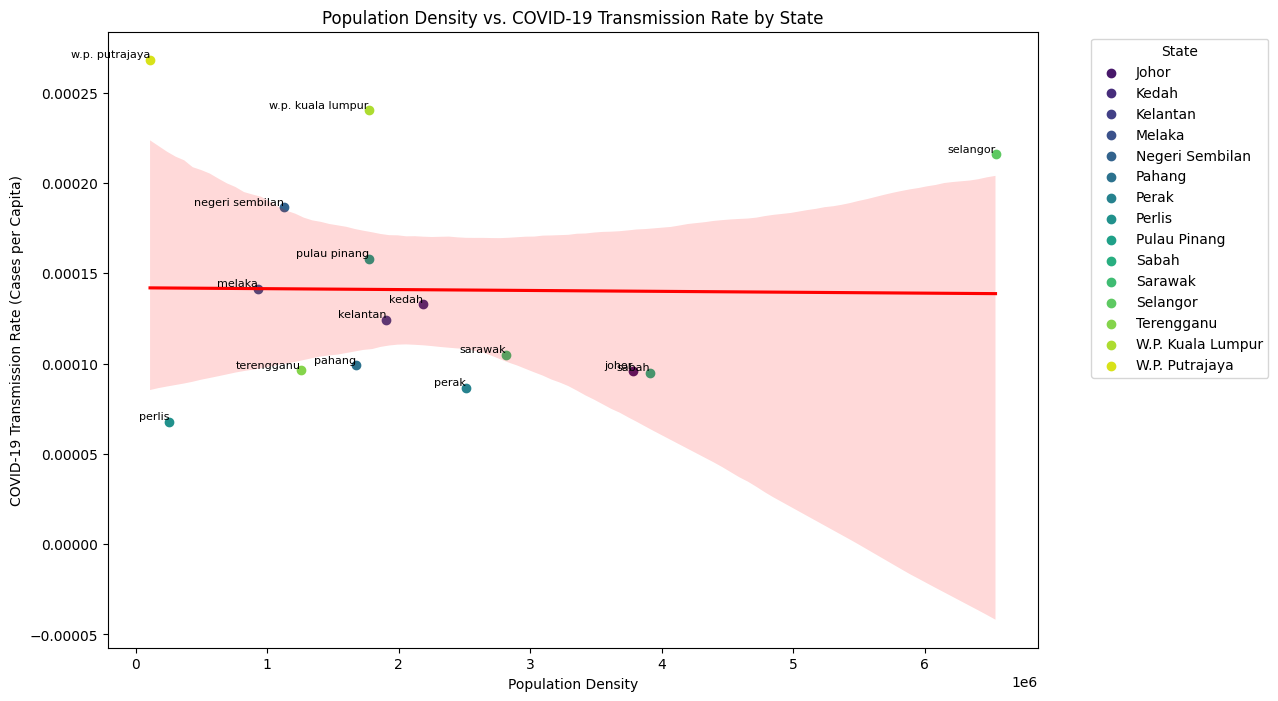

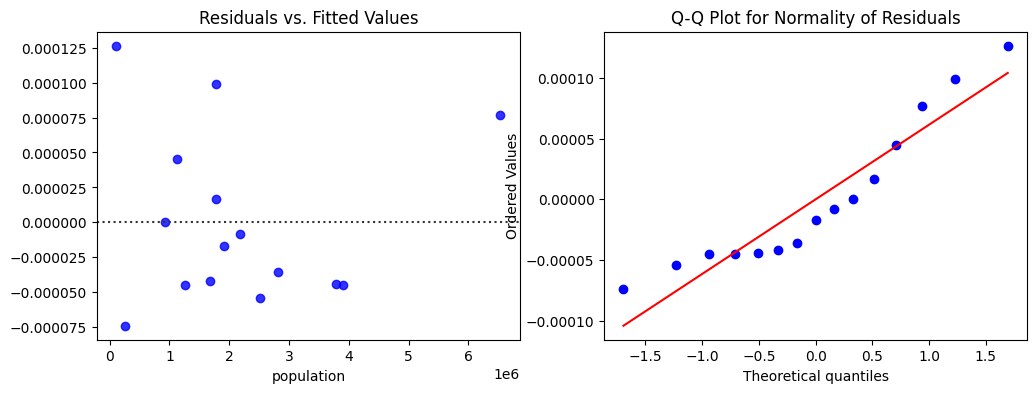

In [23]:
selected_columns = ['state', 'population', 'cases_new_per_capita']
data_to_plot = final_covid_data[selected_columns]

mean_data = data_to_plot.groupby('state').mean()

plt.figure(figsize=(12, 8))
palette = sns.color_palette('viridis', len(mean_data))

for i, (state, row) in enumerate(mean_data.iterrows()):
    color = palette[i]
    plt.scatter(row['population'], row['cases_new_per_capita'], color=color, marker='o', label=state)
    plt.text(row['population'], row['cases_new_per_capita'], state.lower(), fontsize=8, ha='right', va='bottom')

sns.regplot(x='population', y='cases_new_per_capita', data=mean_data, scatter=False, color='red')

plt.title('Population Density vs. COVID-19 Transmission Rate by State')
plt.xlabel('Population Density')
plt.ylabel('COVID-19 Transmission Rate (Cases per Capita)')
plt.legend(title='State', bbox_to_anchor=(1.05, 1), loc='upper left')


plt.savefig('/Users/mona/final-project-monabr4/results/scatter_plot.png')
plt.figure(figsize=(12, 4))

# Residuals vs. Fitted Values (Homoscedasticity)
plt.subplot(1, 2, 1)
residuals = mean_data['cases_new_per_capita'] - sm.OLS(mean_data['cases_new_per_capita'], sm.add_constant(mean_data['population'])).fit().predict(sm.add_constant(mean_data['population']))
sns.residplot(x=mean_data['population'], y=residuals, color='blue')
plt.title('Residuals vs. Fitted Values')

# Q-Q plot for Normality of Residuals
plt.subplot(1, 2, 2)
probplot(residuals, plot=plt)
plt.title('Q-Q Plot for Normality of Residuals')


plt.savefig('/Users/mona/final-project-monabr4/results/covid_plot_with_diagnostics.png')

plt.show()



Spearman's Correlation Results:
Spearman's Correlation Coefficient: -0.2071428571428571
P-value: 0.4588428049634703
The relationship is not statistically significant.


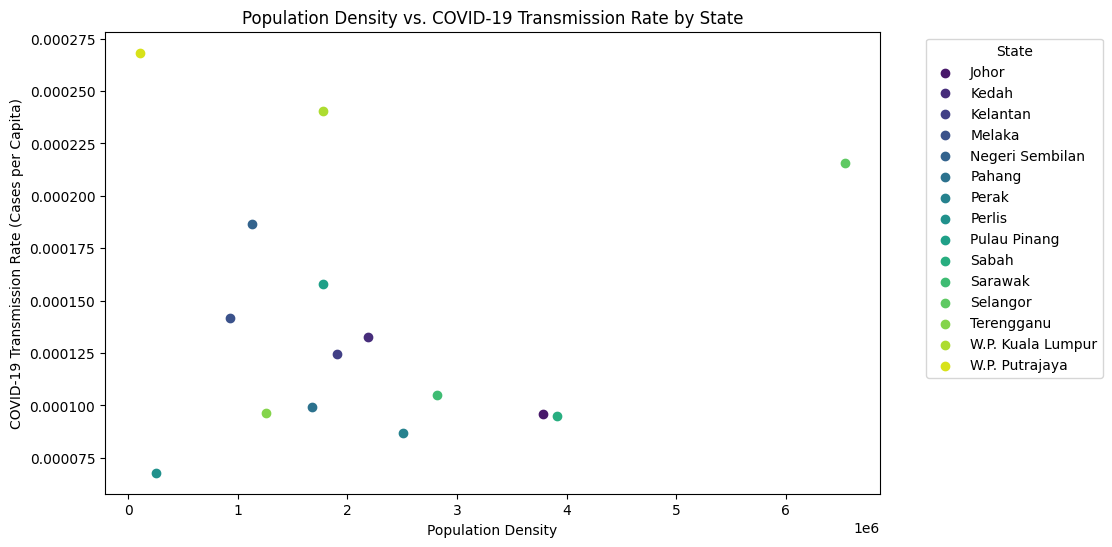

In [30]:
selected_columns = ['state', 'population', 'cases_new_per_capita']
data_to_plot = final_covid_data[selected_columns]

mean_data = data_to_plot.groupby('state').mean()

plt.figure(figsize=(10, 6))
palette = sns.color_palette('viridis', len(mean_data))

for i, (state, row) in enumerate(mean_data.iterrows()):
    color = palette[i]
    plt.scatter(row['population'], row['cases_new_per_capita'], color=color, marker='o', label=state)

plt.title('Population Density vs. COVID-19 Transmission Rate by State')
plt.xlabel('Population Density')
plt.ylabel('COVID-19 Transmission Rate (Cases per Capita)')

plt.legend(title='State', bbox_to_anchor=(1.05, 1), loc='upper left')


spearman_corr, p_value_spearman = spearmanr(mean_data['population'], mean_data['cases_new_per_capita'])
print("Spearman's Correlation Results:")
print(f"Spearman's Correlation Coefficient: {spearman_corr}")
print(f"P-value: {p_value_spearman}")


if p_value_spearman < 0.05:
    print("The relationship is statistically significant.")
else:
    print("The relationship is not statistically significant.")



